In [150]:
import requests

def get_binance_price():
    """바이낸스에서 SHIBUSDT 가격 가져오기"""
    url = "https://api.binance.com/api/v3/ticker/price"
    params = {"symbol": "SHIBUSDT"}
    response = requests.get(url, params=params)
    return float(response.json()["price"])

def get_upbit_price():
    """업비트에서 SHIB/KRW 가격 가져오기"""
    url = "https://api.upbit.com/v1/ticker"
    params = {"markets": "KRW-SHIB"}
    response = requests.get(url, params=params)
    return float(response.json()[0]["trade_price"])

def get_usd_to_krw():
    """신뢰할 수 있는 API에서 환율 가져오기 (네이버 금융)"""
    url = "https://api.exchangerate-api.com/v4/latest/USD"  # 신뢰할 수 있는 환율 API
    response = requests.get(url)
    data = response.json()
    return float(data["rates"]["KRW"])  # USD → KRW 환율 값


In [311]:
# 실시간 데이터 가져오기
binance_price = get_binance_price()  # 바이낸스 가격 (USDT)
upbit_price = get_upbit_price()  # 업비트 가격 (KRW)
usd_to_krw = get_usd_to_krw()  # 환율

# 김치 프리미엄 계산
kimchi_premium = ((upbit_price / (binance_price * usd_to_krw)) - 1) * 100

# 결과 출력
print(f"📌 SHIB 현재 가격 (업비트): {upbit_price} KRW")
print(f"📌 SHIB 현재 가격 (바이낸스): {binance_price} USDT")
print(f"📌 환율 (USD → KRW): {usd_to_krw}")
print(f"🔥 김치 프리미엄: {kimchi_premium:.2f}%")


📌 SHIB 현재 가격 (업비트): 0.01925 KRW
📌 SHIB 현재 가격 (바이낸스): 1.275e-05 USDT
📌 환율 (USD → KRW): 1458.82
🔥 김치 프리미엄: 3.49%


In [176]:
import requests
url = "https://api.binance.com/api/v3/klines"
params = {
    "symbol": "BTCUSDT",
    "interval": "5m",
    "limit": 5
}
response = requests.get(url, params=params)
print(response.json())


[[1741062600000, '83792.14000000', '83827.00000000', '83650.00000000', '83753.32000000', '63.51072000', 1741062899999, '5317831.39021640', 25194, '29.40337000', '2461905.60754180', '0'], [1741062900000, '83753.31000000', '83868.00000000', '83478.58000000', '83643.01000000', '130.34182000', 1741063199999, '10907458.32952280', 31046, '61.28872000', '5132139.82357090', '0'], [1741063200000, '83643.02000000', '83823.52000000', '83622.02000000', '83807.48000000', '49.32260000', 1741063499999, '4129992.64110430', 23365, '20.71977000', '1734968.47799910', '0'], [1741063500000, '83807.48000000', '83812.00000000', '83509.43000000', '83605.00000000', '128.82429000', 1741063799999, '10771611.91534690', 22304, '45.35376000', '3792487.49056470', '0'], [1741063800000, '83605.00000000', '83790.50000000', '83573.46000000', '83678.01000000', '64.30965000', 1741064099999, '5382450.04356030', 21040, '36.02363000', '3014647.72218460', '0']]


In [12]:
# import websocket
# import json

# def on_message(ws, message):
#     data = json.loads(message)
#     print(f"실시간 가격: {data['p']} USDT")  # 'p' = price

# # 웹소켓 연결
# ws = websocket.WebSocketApp("wss://stream.binance.com:9443/ws/shibusdt@trade",
#                              on_message=on_message)
# ws.run_forever()


In [296]:
import requests
import pandas as pd
import time

def get_binance_historical_data(symbol="SHIBUSDT", interval="1h", limit=1000, start_time=None, end_time=None):
    url = "https://api.binance.com/api/v3/klines"
    params = {
        "symbol": symbol,
        "interval": interval,
        "limit": limit
    }
    if start_time:
        params["startTime"] = start_time
    if end_time:
        params["endTime"] = end_time

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()

        if not data:
            print(f"⚠️ {symbol}: API에서 데이터를 가져올 수 없습니다.")
            return None

        df = pd.DataFrame(data, columns=[
            "timestamp", "open", "high", "low", "close", "volume",
            "close_time", "quote_asset_volume", "trades", "taker_base_vol", "taker_quote_vol", "ignore"
        ])
        df = df[["timestamp", "open", "high", "low", "close", "volume"]]
        df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
        df[["open", "high", "low", "close", "volume"]] = df[["open", "high", "low", "close", "volume"]].astype(float)

        return df

    except requests.exceptions.RequestException as e:
        print(f"❌ {symbol}: API 요청 오류 - {e}")
        return None

def get_full_binance_data(symbol="SHIBUSDT", interval="1h", total_candles=50000):
    full_data = pd.DataFrame()
    current_time = int(time.time() * 1000)
    step = 1000 * 60 * 60  # 1시간 단위 (기존 5분에서 수정)

    for i in range(total_candles // 1000 + 1):
        start_time = current_time - (i + 1) * step * 1000
        end_time = current_time - i * step * 1000

        print(f"📊 {symbol}: {i * 1000}개 데이터 가져오는 중...")
        temp_data = get_binance_historical_data(symbol, interval, limit=1000, start_time=start_time, end_time=end_time)

        if temp_data is None or temp_data.empty:
            print(f"⚠️ {symbol}: 더 이상 데이터를 가져올 수 없습니다. ({len(full_data)}개 확보됨)")
            break

        full_data = pd.concat([temp_data, full_data], ignore_index=True)

        # ✅ 속도 조절: 요청 간 1.5~2초 대기
        time.sleep(1.5 + (i % 2) * 0.5)

    print(f"✅ {symbol}: 총 {len(full_data)}개 데이터 확보 완료!")
    return full_data

# ✅ SHIB 데이터 수집
shib_data = get_full_binance_data("SHIBUSDT", interval="1h", total_candles=50000)

# ✅ 📌 데이터 확인 (병합 전)
print("🔍 SHIB 데이터 컬럼:", shib_data.columns.tolist())

# ✅ CSV 저장
shib_data.to_csv("data/shib.csv", index=False)


📊 SHIBUSDT: 0개 데이터 가져오는 중...
📊 SHIBUSDT: 1000개 데이터 가져오는 중...
📊 SHIBUSDT: 2000개 데이터 가져오는 중...
📊 SHIBUSDT: 3000개 데이터 가져오는 중...
📊 SHIBUSDT: 4000개 데이터 가져오는 중...
📊 SHIBUSDT: 5000개 데이터 가져오는 중...
📊 SHIBUSDT: 6000개 데이터 가져오는 중...
📊 SHIBUSDT: 7000개 데이터 가져오는 중...
📊 SHIBUSDT: 8000개 데이터 가져오는 중...
📊 SHIBUSDT: 9000개 데이터 가져오는 중...
📊 SHIBUSDT: 10000개 데이터 가져오는 중...
📊 SHIBUSDT: 11000개 데이터 가져오는 중...
📊 SHIBUSDT: 12000개 데이터 가져오는 중...
📊 SHIBUSDT: 13000개 데이터 가져오는 중...
📊 SHIBUSDT: 14000개 데이터 가져오는 중...
📊 SHIBUSDT: 15000개 데이터 가져오는 중...
📊 SHIBUSDT: 16000개 데이터 가져오는 중...
📊 SHIBUSDT: 17000개 데이터 가져오는 중...
📊 SHIBUSDT: 18000개 데이터 가져오는 중...
📊 SHIBUSDT: 19000개 데이터 가져오는 중...
📊 SHIBUSDT: 20000개 데이터 가져오는 중...
📊 SHIBUSDT: 21000개 데이터 가져오는 중...
📊 SHIBUSDT: 22000개 데이터 가져오는 중...
📊 SHIBUSDT: 23000개 데이터 가져오는 중...
📊 SHIBUSDT: 24000개 데이터 가져오는 중...
📊 SHIBUSDT: 25000개 데이터 가져오는 중...
📊 SHIBUSDT: 26000개 데이터 가져오는 중...
📊 SHIBUSDT: 27000개 데이터 가져오는 중...
📊 SHIBUSDT: 28000개 데이터 가져오는 중...
📊 SHIBUSDT: 29000개 데이터 가져오는 중...
📊 SHIBUSDT: 30000개 데이터 

In [298]:
import numpy as np
import pandas as pd
df = pd.read_csv('data/shib.csv')

In [300]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33444 entries, 0 to 33443
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  33444 non-null  object 
 1   open       33444 non-null  float64
 2   high       33444 non-null  float64
 3   low        33444 non-null  float64
 4   close      33444 non-null  float64
 5   volume     33444 non-null  float64
dtypes: float64(5), object(1)
memory usage: 1.5+ MB
None


In [302]:
df.head()

,timestamp,open,high,low,close,volume
0,2021-05-10 11:00:00,0.000014,0.000050,0.000014,0.000030,1.527431e+13
1,2021-05-10 12:00:00,0.000030,0.000039,0.000029,0.000033,1.290046e+13
2,2021-05-10 13:00:00,0.000033,0.000036,0.000029,0.000031,8.472225e+12
3,2021-05-10 14:00:00,0.000031,0.000031,0.000028,0.000029,5.786327e+12
4,2021-05-10 15:00:00,0.000029,0.000031,0.000029,0.000029,3.593920e+12


In [354]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ✅ 1. 데이터 로드
df = pd.read_csv("data/shib.csv")

# ✅ 2. 타임스탬프 정렬
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values(by="timestamp").reset_index(drop=True)

# ✅ 3. 필요 없는 컬럼 제거
df = df[["timestamp", "open", "high", "low", "close", "volume"]]

# ✅ 4. 결측치 확인 및 제거
df = df.dropna()

# ✅ 5. 정규화 (MinMaxScaler 적용)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[["open", "high", "low", "close", "volume"]])

# ✅ 6. 시퀀스 데이터 생성 (LSTM 입력 형태로 변환)
sequence_length = 50  # 이전 50개의 데이터를 기반으로 예측
X, y = [], []

for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:i + sequence_length])
    y.append(scaled_data[i + sequence_length][3])  # 'close' 가격을 예측

X, y = np.array(X), np.array(y)

# ✅ 7. 훈련/검증/테스트 데이터 분할
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

print(f"✅ 데이터 전처리 완료! (훈련: {len(X_train)}, 검증: {len(X_val)}, 테스트: {len(X_test)})")


✅ 데이터 전처리 완료! (훈련: 26715, 검증: 3339, 테스트: 3340)


Epoch 1/100


C:\Users\kj\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


833/835 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2170
Epoch 1: val_loss improved from inf to 0.03065, saving model to best_model.h5


835/835 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.2167 - val_loss: 0.0306
Epoch 2/100
833/835 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0206
Epoch 2: val_loss improved from 0.03065 to 0.00466, saving model to best_model.h5


835/835 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 0.0205 - val_loss: 0.0047
Epoch 3/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0040
Epoch 3: val_loss improved from 0.00466 to 0.00114, saving model to best_model.h5


835/835 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 0.0040 - val_loss: 0.0011
Epoch 4/100
834/835 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0017
Epoch 4: val_loss improved from 0.00114 to 0.00059, saving model to best_model.h5


835/835 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.0017 - val_loss: 5.8719e-04
Epoch 5/100
834/835 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0012
Epoch 5: val_loss improved from 0.00059 to 0.00046, saving model to best_model.h5


835/835 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 0.0012 - val_loss: 4.5799e-04
Epoch 6/100
833/835 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0011
Epoch 6: val_loss improved from 0.00046 to 0.00042, saving model to best_model.h5


835/835 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.0011 - val_loss: 4.2240e-04
Epoch 7/100
833/835 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0010
Epoch 7: val_loss improved from 0.00042 to 0.00038, saving model to best_model.h5


835/835 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 0.0010 - val_loss: 3.7863e-04
Epoch 8/100
833/835 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0010
Epoch 8: val_loss improved from 0.00038 to 0.00036, saving model to best_model.h5


835/835 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.0010 - val_loss: 3.5696e-04
Epoch 9/100
834/835 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.2004e-04
Epoch 9: val_loss improved from 0.00036 to 0.00036, saving model to best_model.h5


835/835 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - loss: 9.1998e-04 - val_loss: 3.5615e-04
Epoch 10/100
834/835 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 8.9468e-04
Epoch 10: val_loss did not improve from 0.00036
835/835 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 8.9470e-04 - val_loss: 5.6796e-04
Epoch 11/100
834/835 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.7508e-04
Epoch 11: val_loss did not improve from 0.00036
835/835 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 8.7502e-04 - val_loss: 5.1463e-04
Epoch 12/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.6212e-04
Epoch 12: val_loss did not improve from 0.00036
835/835 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 8.6209e-04 - val_loss: 3.8738e-04
Epoch 13/100
834/835 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.4367e-04
Epoch 13: val_loss did not improve from 0.00036
835/835 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 8.4363e-04 - val_loss: 4.8377e-04
Epoch 14/100
834/835 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.7869e-04
Epoch 14: val

835/835 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 7.8067e-04 - val_loss: 3.4864e-04
Epoch 16/100
834/835 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.1795e-04
Epoch 16: val_loss did not improve from 0.00035
835/835 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 7.1805e-04 - val_loss: 3.6413e-04
Epoch 17/100
833/835 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.6875e-04
Epoch 17: val_loss did not improve from 0.00035
835/835 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 7.6865e-04 - val_loss: 4.3512e-04
Epoch 18/100
833/835 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.2496e-04
Epoch 18: val_loss improved from 0.00035 to 0.00034, saving model to best_model.h5


835/835 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 7.2501e-04 - val_loss: 3.4466e-04
Epoch 19/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.0894e-04
Epoch 19: val_loss did not improve from 0.00034
835/835 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 7.0893e-04 - val_loss: 4.3876e-04
Epoch 20/100
834/835 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.8663e-04
Epoch 20: val_loss did not improve from 0.00034
835/835 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 6.8665e-04 - val_loss: 3.7860e-04
Epoch 21/100
833/835 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.7639e-04
Epoch 21: val_loss improved from 0.00034 to 0.00030, saving model to best_model.h5


835/835 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 6.7636e-04 - val_loss: 3.0202e-04
Epoch 22/100
834/835 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.5393e-04
Epoch 22: val_loss improved from 0.00030 to 0.00030, saving model to best_model.h5


835/835 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 7.5374e-04 - val_loss: 2.9998e-04
Epoch 23/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.8058e-04
Epoch 23: val_loss did not improve from 0.00030
835/835 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 6.8056e-04 - val_loss: 4.6227e-04
Epoch 24/100
834/835 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.2724e-04
Epoch 24: val_loss did not improve from 0.00030
835/835 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 6.2731e-04 - val_loss: 3.3132e-04
Epoch 25/100
833/835 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.5150e-04
Epoch 25: val_loss did not improve from 0.00030
835/835 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 6.5152e-04 - val_loss: 3.4307e-04
Epoch 26/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.0655e-04
Epoch 26: val_loss did not improve from 0.00030
835/835 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 6.0657e-04 - val_loss: 4.3261e-04
Epoch 27/100
834/835 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.4902e-04
Epoch 27: val

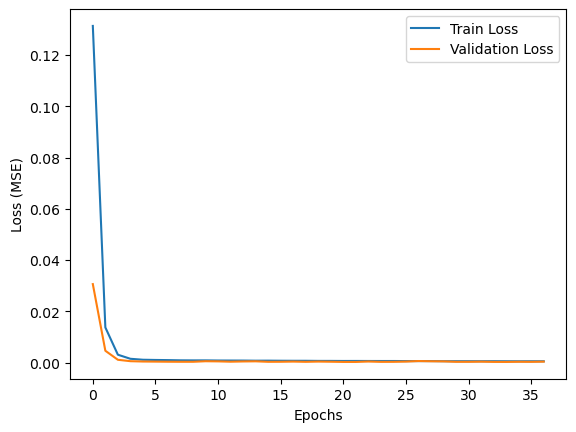

In [368]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import L2


model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=L2(0.003)),
    Dropout(0.4),  

    LSTM(32, return_sequences=False, kernel_regularizer=L2(0.003)),
    Dropout(0.4),

    Dense(16, activation="relu", kernel_regularizer=L2(0.003)),
    Dense(1)
])

# ✅ 모델 컴파일 (학습률 줄임)
model.compile(optimizer=Adam(learning_rate=0.0002), loss="mse")

# ✅ 체크포인트 & 얼리스탑 추가 (patience=15로 증가)
callbacks = [
    ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1)  
]

# ✅ 학습 시작
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=callbacks
)


# ✅ 5. 학습 결과 시각화
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()


In [370]:
history.history

{'loss': [0.13132545351982117,
  0.013751630671322346,
  0.0031142004299908876,
  0.0015223874943330884,
  0.0011515944497659802,
  0.0010643114801496267,
  0.0010057069594040513,
  0.0009206155082210898,
  0.0008959985570982099,
  0.0009000634308904409,
  0.0008496465743519366,
  0.0008387935813516378,
  0.0008280542097054422,
  0.0007793725235387683,
  0.0007949720020405948,
  0.0007586769643239677,
  0.0007410309044644237,
  0.000738638686016202,
  0.0006974010029807687,
  0.0006935603450983763,
  0.0006695370539091527,
  0.0006761152762919664,
  0.0006641876534558833,
  0.000656659307423979,
  0.0006571161211468279,
  0.0006278450600802898,
  0.000624287233222276,
  0.0006255425396375358,
  0.0005838131182827055,
  0.0005803469102829695,
  0.0005782631342299283,
  0.0005732164718210697,
  0.0005841597449034452,
  0.0005612465902231634,
  0.000550667813513428,
  0.0005604175967164338,
  0.0005536246462725103],
 'val_loss': [0.030649196356534958,
  0.004655892960727215,
  0.001138371

✅ 최종 last_sequence.shape: (1, 1, 4)
✅ expected input shape: (None, 1, 4)
✅ Updated max_price used for inverse transform: 8.84845e-05
2025-03-04 16:28:01 - Predicted SHIB Price: 0.00001846 USDT
2025-03-04 17:28:01 - Predicted SHIB Price: 0.00003440 USDT
2025-03-04 18:28:01 - Predicted SHIB Price: 0.00004728 USDT
2025-03-04 19:28:01 - Predicted SHIB Price: 0.00005000 USDT
2025-03-04 20:28:01 - Predicted SHIB Price: 0.00004944 USDT
2025-03-04 21:28:01 - Predicted SHIB Price: 0.00004956 USDT
2025-03-04 22:28:01 - Predicted SHIB Price: 0.00004953 USDT
2025-03-04 23:28:01 - Predicted SHIB Price: 0.00004954 USDT
2025-03-05 00:28:01 - Predicted SHIB Price: 0.00004954 USDT
2025-03-05 01:28:01 - Predicted SHIB Price: 0.00004954 USDT


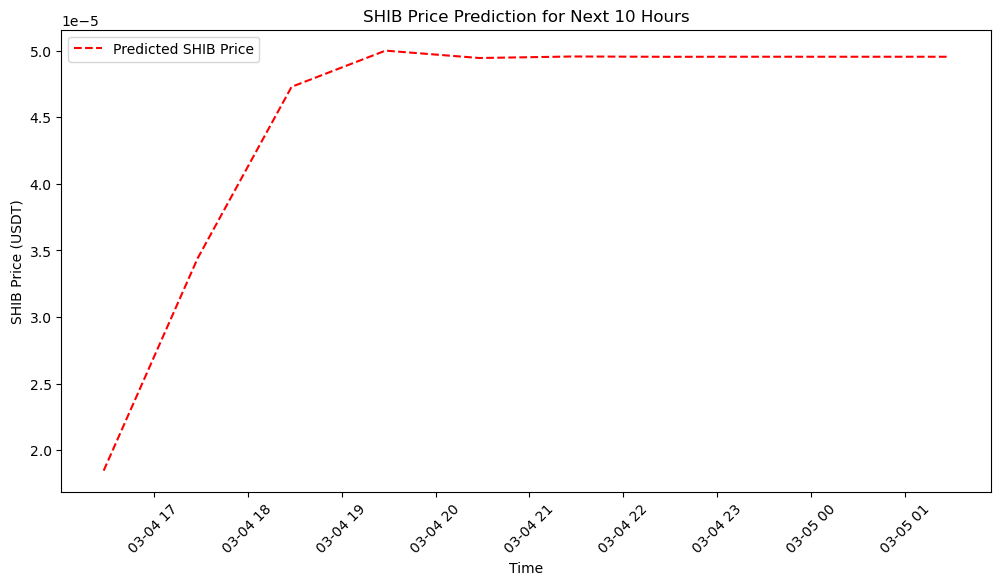

In [444]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def predict_future(model, last_sequence, scaler, num_steps=10, time_interval="1h"):
    """
    모델을 사용하여 미래의 SHIB 가격을 예측합니다.

    Parameters:
        model: 훈련된 LSTM 모델
        last_sequence (numpy array): 마지막 입력 데이터 (1, time_steps, feature_dim)
        scaler: MinMaxScaler 객체 (역정규화에 필요)
        num_steps (int): 예측할 미래 개수 (예: 10시간)
        time_interval (str): 예측 간격 ("5m", "1h", "6h", "24h")

    Returns:
        tuple: (예측된 가격 배열, 시간 리스트)
    """
    future_preds = []
    current_sequence = last_sequence.copy()

    for _ in range(num_steps):
        # ✅ 모델 예측 수행
        next_pred = model.predict(current_sequence, verbose=0)

        # ✅ 예측값 저장
        future_preds.append(next_pred[0, 0])

        # ✅ next_pred를 기존 feature 개수와 일치하도록 확장 (feature_dim=4)
        next_pred_reshaped = np.tile(next_pred, (1, 1, current_sequence.shape[2]))  # (1, 1, 4)

        # ✅ 입력 데이터 업데이트 (예측값 추가하여 시퀀스 이동)
        current_sequence = np.concatenate((current_sequence[:, 1:, :], next_pred_reshaped), axis=1)


    # ✅ SHIB의 가격 데이터만 고려하여 max_price 결정
    max_price = np.percentile(scaler.data_max_[:-1], 99)  # 마지막 값 제외 후 99% 퍼센타일 적용
    print(f"✅ Updated max_price used for inverse transform: {max_price}")
    


    
    # ✅ 역정규화 수행
    future_preds = np.array(future_preds).reshape(-1, 1)  # (num_steps, 1) 형태로 변경
    future_preds = future_preds * (max_price - scaler.data_min_[-1]) + scaler.data_min_[-1]

    # ✅ 미래 시간 생성
    start_time = datetime.now()
    time_delta = {"5m": 5, "1h": 60, "6h": 360, "24h": 1440}
    time_steps = [start_time + timedelta(minutes=time_delta[time_interval] * i) for i in range(num_steps)]

    return future_preds, time_steps


# ✅ 마지막 입력 데이터 가져오기
last_sequence = X_test[-1]  # (time_steps, feature_dim) 형태

# 🚨 feature 개수 조정 (5 → 4)
feature_dim = trained_model.input_shape[-1]
last_sequence = last_sequence[:, :feature_dim]  # 첫 4개 feature만 사용

# 🚨 입력 타임스텝을 1개로 변환
last_sequence = last_sequence[-1:]  # 마지막 행 선택 → (1, 4)

# ✅ 배치 차원 추가 (1, 1, 4)로 변환
last_sequence = np.expand_dims(last_sequence, axis=0).astype(np.float32)

# ✅ 입력 데이터 검증
print(f"✅ 최종 last_sequence.shape: {last_sequence.shape}")
print(f"✅ expected input shape: {trained_model.input_shape}")

# ✅ 예측 수행 (1시간 단위, 10개 시점)
num_steps = 10
predicted_prices, future_times = predict_future(trained_model, last_sequence, scaler, num_steps=num_steps, time_interval="1h")

# ✅ 예측 결과 출력 (가격을 float로 변환)
for t, price in zip(future_times, predicted_prices.flatten()):  # 👈 .flatten() 추가
    print(f"{t.strftime('%Y-%m-%d %H:%M:%S')} - Predicted SHIB Price: {float(price):.8f} USDT")


# 📈 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(future_times, predicted_prices, label="Predicted SHIB Price", linestyle='dashed', color='red')

plt.xlabel('Time')
plt.ylabel('SHIB Price (USDT)')
plt.xticks(rotation=45)
plt.legend()
plt.title(f"SHIB Price Prediction for Next {num_steps} Hours")

plt.show()
